In [1]:
import os
import numpy as np
import PIL
import torch
import torch.nn as nn
from PIL import Image

from transformers import OwlViTConfig, OwlViTProcessor, OwlViTForObjectDetection

## Load model and processor

In [2]:
model = OwlViTForObjectDetection.from_pretrained("adirik/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("adirik/owlvit-base-patch32")

## Prepare image and text queries

In [3]:
img_paths = ['astronaut.png', 'motorcycle_right.png']
images = [Image.open(p) for p in img_paths]

text = [
    ['human face', 'rocket', 'nasa badge', 'star-spangled banner'], 
    ["yellow bottle", "box", "motorcycle"]
]

inputs = processor(text=text, images=images, return_tensors="pt", padding="max_length")

## Get predictions

In [7]:
outputs = model(**inputs, return_dict=True)

## Draw predictions on image

In [8]:
from matplotlib import pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()


# Load example image
image = Image.open("astronaut.png")
image = mixin.resize(image, 768)
input_image = np.asarray(image).astype(np.float32) / 255.0
input_text = text[0]

/opt/miniconda3/envs/hf/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


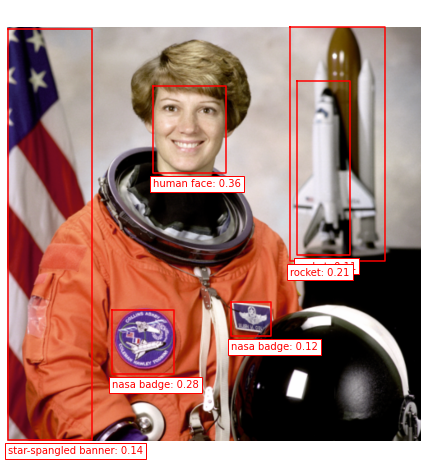

In [9]:
score_threshold = 0.1

# Get predicted logits
logits = torch.max(outputs['logits'][0], dim=-1)
scores = nn.functional.sigmoid(logits.values).detach().numpy()

# Get predicted labels and boundary boxes
labels = logits.indices.detach().numpy()
boxes = outputs['pred_boxes'][0].detach().numpy()


# Plot predictions
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], "r")
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{input_text[label]}: {score:1.2f}',
      ha="left",
      va="top",
      color="red",
      bbox={
          "facecolor": "white",
          "edgecolor": "red",
          "boxstyle": "square,pad=.3"
      })